In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import seaborn as sns
from scipy.linalg import pinv
from IPython.display import display, Math
import matplotlib.lines as mlines
import matplotlib.colors as mcolors

import sys
import os
sys.path.append(os.path.abspath('../../utils'))
from Perturbe_Algs import Attacks


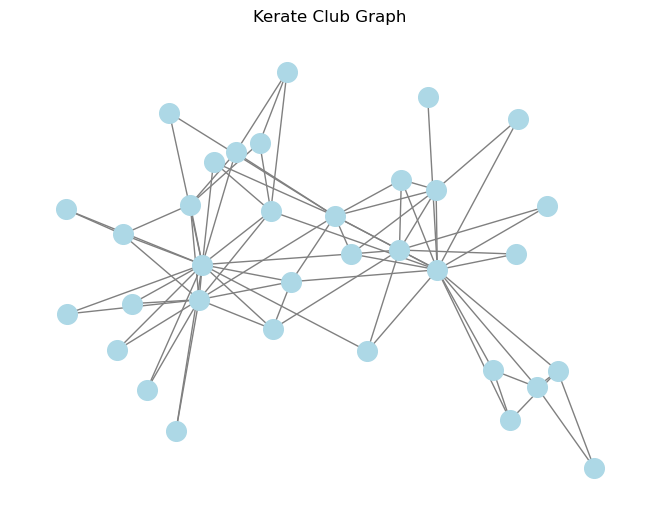

In [16]:
# Generate a KC graph
G = G = nx.karate_club_graph()
N = G.number_of_nodes()
pos = nx.spring_layout(G)  

nx.draw(G, pos, node_color='lightblue', with_labels=False, node_size=200, edge_color='gray')
plt.title('Kerate Club Graph')
plt.show()


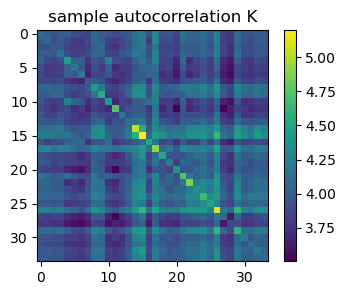

In [23]:
# Sample a signal on the graph
d = 100
J = np.ones((N,N))
I = np.eye(N)
A = nx.adjacency_matrix(G).todense()
A = (A>0).astype(int)
L = np.diag(np.sum(A,axis = 0)) - A
L_pinv = pinv(L)
# Define the covariance matrix. 
# Here we use the inverse of the Laplacian matrix to generate smoothe signals.
mean = 2*np.ones((N,1))
cov = L_pinv
K = mean@mean.T + cov
X = np.random.multivariate_normal(mean.flatten(), cov, size=d).T 

# Compute the sample covariance matrix
K_samp = X@X.T/d
plt.figure(figsize = (4,3))
plt.imshow(K_samp,interpolation='None')
plt.colorbar()
plt.title('sample autocorrelation K')
plt.show()


In [25]:
# Set up parameters for the attack
A = torch.tensor(A).type(torch.double)
n = A.shape[0]
K_samp = torch.tensor(K_samp).type(torch.double)
X = torch.tensor(X).type(torch.double)
m = 20
print(f'Perturbe {m: d} edges')
alpha = 1
max_iter = 100
mute = True


Perturbe  20 edges


/var/folders/g5/2bq04cqs5_ndzg2hlc5lx8dr0000gr/T/ipykernel_43587/2648938276.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A).type(torch.double)
/var/folders/g5/2bq04cqs5_ndzg2hlc5lx8dr0000gr/T/ipykernel_43587/2648938276.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  K_samp = torch.tensor(K_samp).type(torch.double)
/var/folders/g5/2bq04cqs5_ndzg2hlc5lx8dr0000gr/T/ipykernel_43587/2648938276.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).type(torch.double)


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Attack_KC = Attacks(A, K_samp, m, alpha, max_iter,filter = 'adj').to(device)

A_pgd_wst = Attack_KC.pgd_wst()
A_random = Attack_KC.randomAttack()
A_pgd_avg = Attack_KC.pgd_avg()



Using device: cpu


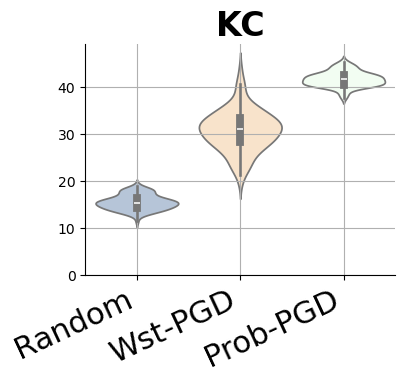

In [27]:

delta_x_random = np.zeros(d)
delta_x_pgd_avg = np.zeros(d)
delta_x_pgd_wst = np.zeros(d)

for j in range(d):
  delta_x_random[j] = torch.norm(((A-A_random) ) @ X[:,j], p ='fro').item()
  delta_x_pgd_avg[j] = torch.norm(((A-A_pgd_avg) ) @ X[:,j], p ='fro').item()
  delta_x_pgd_wst[j] = torch.norm(((A-A_pgd_wst) ) @ X[:,j], p ='fro').item()



data = [delta_x_random, delta_x_pgd_wst, delta_x_pgd_avg]
labels = ['Random', 'Wst-PGD', 'Prob-PGD']
colors = ['lightsteelblue', 'bisque', 'honeydew']

plt.figure(figsize=(4, 3))
sns.violinplot(data=data, palette=colors)
plt.ylim(0, None)
plt.xticks(range(len(labels)), labels, fontsize = 22,rotation=25, ha='right')
plt.title("KC",fontsize = 24,fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(True)
plt.show()



/var/folders/g5/2bq04cqs5_ndzg2hlc5lx8dr0000gr/T/ipykernel_43587/1537884237.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


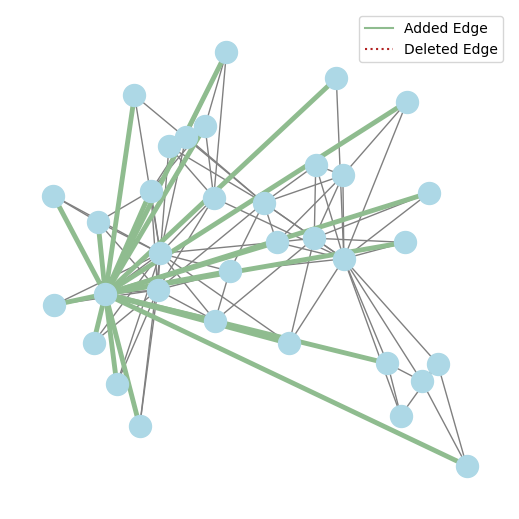

In [28]:
A_modified = A_pgd_avg
A_original = A

# Find the differences between the original and modified matrices
diff_matrix = A_modified - A_original

  # Create a list to store edges to be highlighted
edges_to_highlight = []
for i in range(diff_matrix.shape[0]):
    for j in range(i + 1, diff_matrix.shape[1]):  # Iterate over upper triangle
        if diff_matrix[i, j] == 1:  # Added edge
            edges_to_highlight.append((i, j, 'added'))
        elif diff_matrix[i, j] == -1:  # Deleted edge
            edges_to_highlight.append((i, j, 'deleted'))

# Visualize the graph with highlighted edges
plt.figure(figsize=(5, 5))
nx.draw(G, pos, node_color='lightblue', node_size=250, edge_color='gray', with_labels=False)

# Highlight modified edges
for u, v, edge_type in edges_to_highlight:
    if edge_type == 'added':
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color='#8FBC8F', width=3.5)
    elif edge_type == 'deleted':
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color='#B22222', style=':', width=3.5)

added_edge_line = mlines.Line2D([], [], color='#8FBC8F', label='Added Edge', linestyle='-')
deleted_edge_line = mlines.Line2D([], [], color='#B22222', label='Deleted Edge', linestyle=':')
plt.legend(handles=[added_edge_line, deleted_edge_line])
# plt.title("Structured perturbation")
plt.tight_layout()
# plt.savefig("KC_A_structure.pdf",bbox_inches='tight', pad_inches=0.1)
plt.show()
